In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate

/home/dqw_lcd/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Loading datasets
dataseta = pd.read_csv('dataseta.csv')
datasetb = pd.read_csv('datasetb.csv')

In [7]:
# cell column as same datatype 
dataseta['cell'] = dataseta['cell'].astype(str)
datasetb['cell'] = datasetb['cell'].astype(str)

In [3]:
# Aamir encoding SMILES strings
def encode_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return [Descriptors.MolWt(mol), Descriptors.MolLogP(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol)]

# Applying SMILES encoding
dataseta['drug1_features'] = dataseta['drug1'].apply(encode_smiles)
dataseta['drug2_features'] = dataseta['drug2'].apply(encode_smiles)

# expanding SMILES features into separate columns
def expand_features(row):
    return pd.Series(row['drug1_features'] + row['drug2_features'])

# Expand drug features
expanded_features = dataseta.apply(expand_features, axis=1)

In [8]:
# merge datasets on 'cell' column
combined_dataset = pd.merge(dataseta[['cell', 'label']], datasetb, on='cell')
combined_expanded_dataset = pd.concat([combined_dataset, expanded_features], axis=1)


In [9]:
# handle preprocess gene expression data
scaler = StandardScaler()
gene_expression = combined_expanded_dataset.drop(['cell', 'label'], axis=1)
gene_expression_scaled = scaler.fit_transform(gene_expression)

/home/dqw_lcd/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/dqw_lcd/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [10]:
# Split combined dataset for training and testing
X_gene_train, X_gene_test, y_train, y_test = train_test_split(gene_expression_scaled, combined_expanded_dataset['label'], test_size=0.2, random_state=42)


In [11]:
# MLP for gene expression data
input_b = Input(shape=(X_gene_train.shape[1],))
hidden_b = Dense(64, activation='relu')(input_b)
hidden_b = Dense(32, activation='relu')(hidden_b)
output_b = Dense(1, activation='sigmoid')(hidden_b)
mlp_model = Model(inputs=input_b, outputs=output_b)
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
# Train MLP
mlp_model.fit(X_gene_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
311/311 [==============================] - 2s 3ms/step - loss: 0.7322 - accuracy: 0.5318
Epoch 2/10
311/311 [==============================] - 1s 3ms/step - loss: 0.7025 - accuracy: 0.5401
Epoch 3/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6961 - accuracy: 0.5453
Epoch 4/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6975 - accuracy: 0.5380
Epoch 5/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6949 - accuracy: 0.5423
Epoch 6/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6919 - accuracy: 0.5482
Epoch 7/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.5509
Epoch 8/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.5504
Epoch 9/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6880 - accuracy: 0.5555
Epoch 10/10
311/311 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.5510

In [13]:
# XGBoost for SMILES data
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_gene_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [14]:
# Predictions from both models for the test set
mlp_predictions = mlp_model.predict(X_gene_test)
xgb_predictions = xgb_model.predict_proba(X_gene_test)[:, 1]

78/78 [==============================] - 0s 2ms/step


In [15]:
# Concatenate MLP and XGBoost outputs
concatenated_features = np.concatenate([mlp_predictions, xgb_predictions.reshape(-1, 1)], axis=1)


In [16]:
# Fully connected layer for final prediction
final_input = Input(shape=(2,))
final_output = Dense(1, activation='sigmoid')(final_input)
final_model = Model(inputs=final_input, outputs=final_output)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# Train final model
final_model.fit(concatenated_features, y_test, epochs=10, batch_size=32)


Epoch 1/10
78/78 [==============================] - 1s 3ms/step - loss: 0.7345 - accuracy: 0.4938
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 0.7151 - accuracy: 0.4938
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 0.7011 - accuracy: 0.4994
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5091
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.5256
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5469
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5594
Epoch 8/10
78/78 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.5759
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5820
Epoch 10/10
78/78 [==============================] - 0s 2ms/step - loss: 0.6754 - accuracy: 0.5977


In [18]:
# final model prediction
final_predictions = final_model.predict(concatenated_features)

78/78 [==============================] - 1s 7ms/step


In [19]:
# predictions to binary cnvrsion
final_binary_predictions = (final_predictions > 0.5).astype(int)

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/dqw_lcd/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [22]:
# accuracy
accuracy = accuracy_score(y_test, final_binary_predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6073298429319371


In [24]:

# ROC-AUC curve
fpr, tpr, thresholds = roc_curve(y_test, final_predictions)
roc_auc = auc(fpr, tpr)

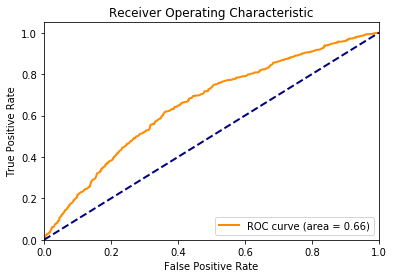

In [25]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


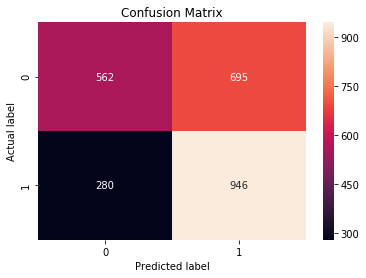

In [26]:
# confusion mtrx
cm = confusion_matrix(y_test, final_binary_predictions)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()